<a href="https://colab.research.google.com/github/nicoussj/MachineLearning/blob/main/RandomForestClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

##Dataset

In [ ]:
# Subir archivo
uploaded = files.upload()
for fn in uploaded.keys():
    name = fn

# Leer CSV
df = pd.read_csv(name, sep=';', encoding='latin1')
df.columns = df.columns.str.replace(';', '')

# Limpiar columnas no necesarias
df = df.drop(columns=['Unnamed: 0', 'AbnormalMatch'], errors='ignore')

# Corregir valores erróneos manuales si existen
df['RoundWinner'] = df['RoundWinner'].replace('False4', 'False')
df['MatchWinner'] = df['MatchWinner'].fillna('False')

# Convertir a binario
df['RoundWinner'] = df['RoundWinner'].astype(str).map({'True': 1, 'False': 0})
df['MatchWinner'] = df['MatchWinner'].astype(str).map({'True': 1, 'False': 0})
df['Survived'] = df['Survived'].astype(str).map({'True': 1, 'False': 0})

# Convertir columnas numéricas que vienen con formato incorrecto
features = ['TimeAlive', 'TravelledDistance', 'RoundKills', 'MatchKills', 'RoundAssists', 'MatchAssists', 'RoundHeadshots']

for col in features:
    df[col] = df[col].astype(str).str.replace('.', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Eliminar filas con datos inválidos
df = df.dropna(subset=features + ['RoundWinner'])


Saving Anexo ET_demo_round_traces_2022.csv to Anexo ET_demo_round_traces_2022.csv


/tmp/ipython-input-4-3294775249.py:7: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(name, sep=';', encoding='latin1')


##RandomForestClassifier con Curva Roc

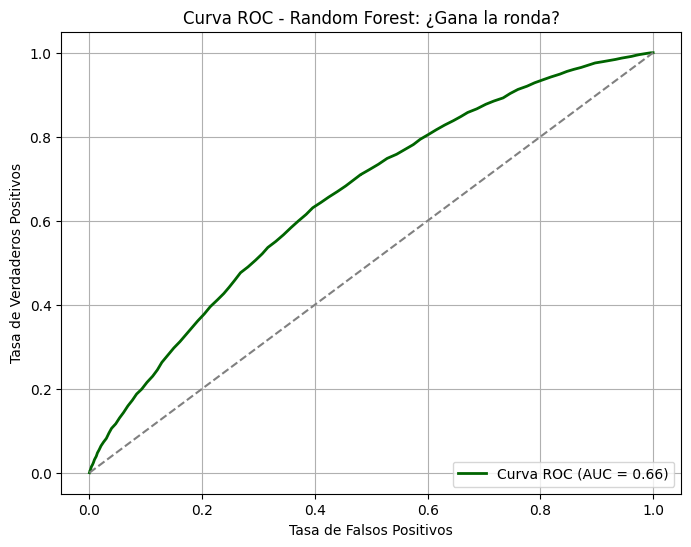


Métricas Binarias - Random Forest:

Accuracy:  0.62
Precision: 0.62
Recall:    0.63
F1 Score:  0.62

Matriz de Confusión:
[[4760 3122]
 [2936 5013]]

Reporte de Clasificación:
              precision    recall  f1-score   support

      Pierde       0.62      0.60      0.61      7882
        Gana       0.62      0.63      0.62      7949

    accuracy                           0.62     15831
   macro avg       0.62      0.62      0.62     15831
weighted avg       0.62      0.62      0.62     15831



In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_curve, auc, classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)
import matplotlib.pyplot as plt

# Variables
features = ['TimeAlive', 'TravelledDistance', 'RoundKills', 'MatchKills', 'RoundAssists', 'MatchAssists', 'RoundHeadshots']
X = df[features]
y = df['RoundWinner'].astype(int)

# Dividir el dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo Random Forest con balanceo de clases
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Predicciones
y_pred_proba = model.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Gráfico ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - Random Forest: ¿Gana la ronda?')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Métricas binaria
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

# Resultados
print("\nMétricas Binarias - Random Forest:\n")
print(f"Accuracy:  {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")
print(f"F1 Score:  {f1:.2f}")
print("\nMatriz de Confusión:")
print(cm)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=["Pierde", "Gana"]))


##Probabilidad promedio de ganar rondas por equipo

In [ ]:

if 'Team' in df.columns:
    # Agregamos la columna de predicción al conjunto de prueba
    df_test = X_test.copy()
    df_test['Predicted_Prob'] = y_pred_proba
    df_test['Team'] = df.loc[X_test.index, 'Team']  # O el nombre correcto de la columna de equipo

    # Calcular la probabilidad media de ganar por equipo
    team_win_prob = df_test.groupby('Team')['Predicted_Prob'].mean().sort_values(ascending=False)

    print("\nProbabilidad Promedio de Ganar Rondas por Equipo (según el modelo):")
    print(team_win_prob.head(10))  # Top 10 equipos
else:
    print("No se encontró una columna 'Team' en el DataFrame. Agrega una para poder calcular métricas por equipo.")



Probabilidad Promedio de Ganar Rondas por Equipo (según el modelo):
Team
Terrorist           0.525319
CounterTerrorist    0.476618
Name: Predicted_Prob, dtype: float64


##Importancia de las Variables

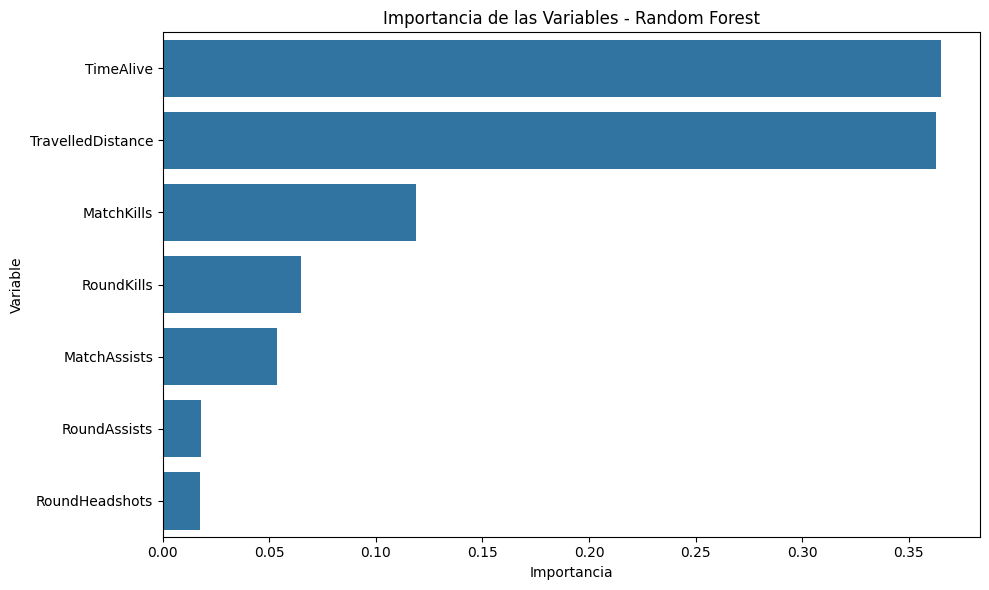

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Importancia de las variables
importances = model.feature_importances_
feature_names = X.columns
feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Gráfico de barras sin palette para evitar warning
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)  # <-- aquí quité palette
plt.title('Importancia de las Variables - Random Forest')
plt.xlabel('Importancia')
plt.ylabel('Variable')
plt.tight_layout()
plt.show()



Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.63      0.65      0.64      7882
           1       0.64      0.63      0.63      7949

    accuracy                           0.64     15831
   macro avg       0.64      0.64      0.64     15831
weighted avg       0.64      0.64      0.64     15831



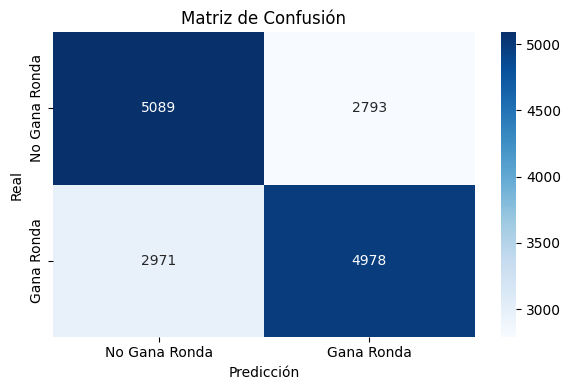

In [ ]:
# Entrenar modelo Random Forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Evaluación
y_pred = rf.predict(X_test)
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Matriz de confusión
plt.figure(figsize=(6,4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Gana Ronda", "Gana Ronda"],
            yticklabels=["No Gana Ronda", "Gana Ronda"])
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.title("Matriz de Confusión")
plt.tight_layout()
plt.show()
